# CLUSTERING WITH DBSCAN

Cluster Analysis is an important problem in data analysis. Data scientists use clustering to identify malfunctioning servers, group genes with similar expression patterns, or various other applications.

K-Means determines `k` centroids in the data and clusters points by assigning them to the nearest centroid. While K-Means is easy to understand and implement in practice, the algorithm has no notion of outliers, so all points are assigned to a cluster even if they do not belong in any. In the domain of anomaly detection, this causes problems as anomalous points will be assigned to the same cluster as "normal" data points. The anomalous points pull the cluster centroid towards them, making it harder to classify them as anomalous points.

Compared to centroid-based clustering like K-Means, density-based clustering works by identifying "dense" clusters of points, allowing it to learn clusters of arbitrary shape and identify outliers in the data. 

## Preliminary: ɛ-Balls and neighborhood density

Before we can discuss density-based clustering, we first need to cover a topic that you may have seen in a topology course: ɛ-neighborhoods.

The general idea behind ɛ-neighborhoods is given a data point, we want to be able to discover the data points in the space around it. Formally, for some real-valued ɛ > 0 and some point p, the ɛ-neighborhood of p is defined as the set of points that are at most distance ɛ away from p.

If you think back to geometry, the shape in which all points are equidistant from the center is the circle. In 2D space, the ɛ-neighborhood of a point p is the set of points contained in a circle of radius ɛ, centered at p. In 3D space, the ɛ-neighborhood is a sphere of radius ɛ, centered at p, and in higher dimensional space, the ɛ-neighborhood is just the N-sphere of radius ɛ, centered at p.

Let's consider an example to make this idea more concrete - scattered 100 data points in the interval [1,3] X [2,4]. Let's pick the point (3,2) to be our point p.

In [1]:
import pandas as pd
import numpy as np

from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

## Epsilon-Balls

In [2]:
test_pt = np.array([3,2])

# Generate 100 2-dimesional points (x,y) around (3,2).  rand() generates numbers between (0, 1).  Scale them by 1.5 
datapoints = 1.5 * (np.random.rand(100, 2) - 0.5) + test_pt

In [3]:
def compute_balls(data, epsilon=0.5):
    # linspace() returns evenly spaced numbers over a specified interval; here 100 samples over [0, 2*pi], where each 
    # value, θ is the angle in radians (full circle)
    circle = np.linspace(0, 2*np.pi, 100)
    neighborhood = []
    data_x, data_y = data  # unpack the 'data' tuple into 'data_x' and 'data_y' variables
    
    # Create a circle of radius epsilon (0.5) around the given data point
    for direction in circle:  # loop through each direction angle in the circle
        x_pos = data_x + epsilon*np.cos(direction)  # calculate x-coordinate using polar coordinates
        y_pos = data_y + epsilon*np.sin(direction)  # calculate y-coordinate using polar coordinates
        neighborhood.append((x_pos,y_pos))          # append the coordinates to the 'neighborhood' list
    return neighborhood

In [4]:
neighborhood = compute_balls(test_pt, epsilon = 0.15)

In [5]:
names = ["Abraham", "Mary", "Edward", "Willie", "Tad"]
years = [1809, 1818, 1846, 1850, 1853]

the_lincolns = list(zip(names, years))

# Copy the zip lists because once we iterate over the_lincolns once using list(the_lincolns), the iterator
# is exhausted, and subsequent attempts to unpack it using zip(*the_lincolns) result in an empty iterable
lincolns = the_lincolns.copy()
lincolns

[('Abraham', 1809),
 ('Mary', 1818),
 ('Edward', 1846),
 ('Willie', 1850),
 ('Tad', 1853)]

In [6]:
first_names, birth_years = zip(*the_lincolns)
print(list(first_names))
print(list(birth_years))

['Abraham', 'Mary', 'Edward', 'Willie', 'Tad']
[1809, 1818, 1846, 1850, 1853]


In [7]:
# The * operator is used to unpack the elements of 'neighborhood' so that zip receives individual coordinate pairs
X, Y = zip(*neighborhood)        # unpack the 'neighborhood' list of coordinates into separate X and Y lists
X, Y = np.array(X), np.array(Y)  # convert the X and Y lists into NumPy arrays so they be used with various NumPy functions

In [8]:
print(test_pt)
test_pt.reshape(1,2)

[3 2]


array([[3, 2]])

In [9]:
# Count the number of elements in the list of distances that are less than 0.15
# • filter(lambda x: x < 0.15, cdist(datapoints, test_pt.reshape(1, 2)))
#   filter out elements from the distances computed by cdist based on the lambda function
# • lambda x: x < 0.15 returns True if the input x is less than 0.15 and False otherwise.  
#   It is used as the filtering criterion for the filter function
# • scipy::cdist() computes the distance between each pair of points
#   SciPy is a collection of mathematical algorithms and convenience functions built on NumPy
# • test_pt = [3, 2], test_pt.reshape(1,2) = array([[3, 2]])
count = len(list(filter(lambda x: x < 0.15, cdist(datapoints, test_pt.reshape(1,2)))))

Text(0.5, 1.0, 'Density-Reachable with radius 0.15')

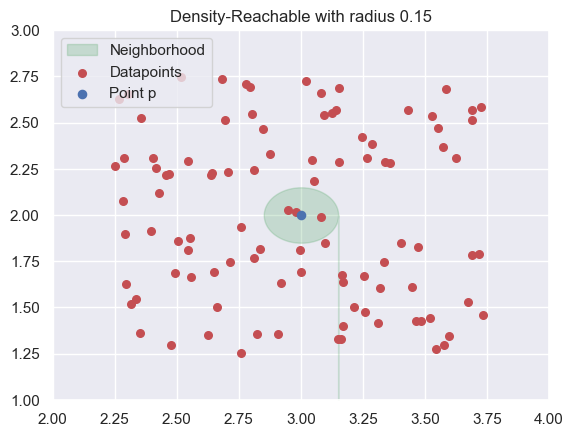

In [10]:
# # Fill the area between the curves defined by X and Y with a green color, setting transparency (alpha) to 0.25
plt.fill_between(X, Y, alpha = 0.25, color='g', label="Neighborhood")

# Scatter plot of datapoints, setting marker size (s) to 30, and color to red
plt.scatter(datapoints[:,0], datapoints[:,1], s=30, color='r',label="Datapoints")

# Scatter plot of the origin, 'test_pt', with a marker size of 35
plt.scatter(test_pt[0],test_pt[1], s=35, label="Point p")

# Set the x-axis limits to the range [2, 4], y-axis limits to the range [1, 3]
plt.xlim(2,4)
plt.ylim(1,3)

# Add a legend to the plot at location 2 (upper left corner)
plt.legend(loc=2)
plt.title("Density-Reachable with radius 0.15")
#plt.savefig("results/neighborhood_reachable_base.png", format="PNG")

The opaque green oval represents our neighborhood, and there are 6 data points in this neighborhood. Since we scattered 100 data points and 6 are in the neighborhood, this means that a 6% of the data points are contained within the neighborhood of p with radius 0.15.

Now that we have defined what we mean by a "neighborhood", we'll introduce the next important concept: the notion of a "density" for a neighborhood (we're building up to describing "density-based clustering, after all).

In a grade-school science class, children are taught that density = mass/volume. Let's use this idea of mass divided by volume to define density at some point p. If we consider some point p and its neighborhood of radius ɛ, we can define the mass of the neighborhood as the number of data points (or alternatively, the fraction of data points) contained within the neighborhood, and the volume of the neighborhood is volume of the resulting shape of the neighborhood. In the 2D case, the neighborhood is a circle, so the volume of the neighborhood is just the area of the resulting circle. In the 3D and higher dimensional case, the neighborhood is a sphere or n-sphere, so we can calculate the volume of this shape.

The mass is the number of data points in the neighborhood, so mass = 31. The volume is the area of the circle, so volume = π0.52 = π/4. Therefore, our local density approximation at *p = (3,2) is calculated as density = mass/volume = 31/(π/4) = 124/π ~= 39.5.

This value is meaningless by itself, but if we calculate the local density approximation for all points in our dataset, we could cluster our points by saying that points that are nearby (contained in the same neighborhood) and have similar local density approximations belong in the same cluster. If we decrease the value of ɛ, we can construct smaller neighborhoods (less volume) that would also contain fewer data points. Ideally, we want to identify highly dense neighborhoods where most of the data points are contained in these neighborhoods, but the volume of each of these neighborhoods is relatively small.

While this is not exactly what DBSCAN algorithm does, it forms the general intuition behind density-based clustering.

To recap, we discussed the ɛ-neighborhoods and how they allow us to reason about the space around a particular point. Then we defined a notion of density at a particular point for a particular neighborhood. In the next section, we'll discuss the DBSCAN algorithm where the ɛ-ball is a fundamental tool for defining clusters.

Text(0.5, 1.0, 'Density-Reachable with radius 0.50')

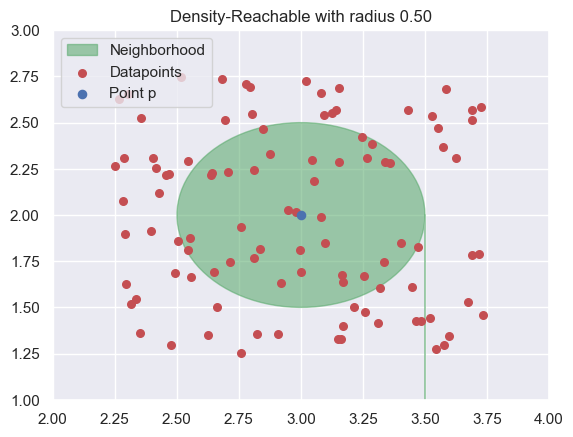

In [11]:
# Here, the radius is 0.5 vs 0.15 in the previous calculation of the neighborhood
neighborhood = compute_balls(test_pt, epsilon=0.50)
X,Y = zip(*neighborhood)
X,Y = np.array(X),np.array(Y)
count = len(list(filter(lambda x: x < 0.15, cdist(datapoints, test_pt.reshape(1,2)))))

plt.fill_between(X, Y, alpha = 0.55, color = 'g', label = "Neighborhood")
plt.scatter(datapoints[:,0], datapoints[:,1], s=30, color='r',label = "Datapoints")
plt.scatter(test_pt[0],test_pt[1], s = 35, label = "Point p")
plt.xlim(2,4)
plt.ylim(1,3)
plt.legend(loc=2)
plt.title("Density-Reachable with radius 0.50")

## DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is the most well-known density-based clustering algorithm.

Unlike K-Means, DBSCAN does not require the number of clusters as a parameter. Rather it infers the number of clusters based on the data, and it can discover clusters of arbitrary shape (for comparison, K-Means usually discovers spherical clusters). As I said earlier, the ɛ-neighborhood is fundamental to DBSCAN to approximate local density, so the algorithm has two parameters:

1. ɛ: The radius of our neighborhoods around a data point p.
2. minPts: The minimum number of data points we want in a neighborhood to define a cluster.

Using these two parameters, DBSCAN categorizes the data points into three categories:

- `Core Points`: A data point p is a core point if Nbhd(p,ɛ) [ɛ-neighborhood of p] contains at least minPts ; | Nbhd(p,ɛ) | >= minPts.

- `Border Points`: A data point *q is a border point if Nbhd(q, ɛ) contains less than minPts data points, but q is reachable from some core point p.

- `Outlier`: A data point o is an outlier if it is neither a core point nor a border point. Essentially, this is the "other" class.

These definitions may seem abstract, so let's cover what each one means in more detail.

### CORE POINTS

Core Points are the foundations for DBSCAN clusters and are based on the density approximation. We use the same ɛ to compute the neighborhood for each point, so the volume of all the neighborhoods is the same. However, the number of other points in each neighborhood is what differs. Recall that we can think of the number of data points in the neighborhood as its mass. The volume of each neighborhood is constant, and the mass of neighborhood is variable, so by putting a threshold on the minimum amount of mass needed to be core point, we are essentially setting a minimum density threshold. Therefore, core points are data points that satisfy a minimum density requirement. Our clusters are built around our core points (hence the core part), so by adjusting our minPts parameter, we can fine-tune how dense our clusters cores must be.

### BORDER POINTS

Border Points are the points in our clusters that are not core points. In the definition above for border points, we used the term density-reachable. we have not defined this term yet, but the concept is simple. To explain this concept, let's revisit our neighborhood example with epsilon = 0.15. Consider the point r (the black dot) that is outside of the point p's neighborhood.

<img src="images/dbscan-1.png" alt="image1" style="width: 600px;height: 400px"/>


All the points inside the point p's neighborhood are said to be directly reachable from p. Now, let's explore the neighborhood of point q, a point directly reachable from p. The yellow circle represents q's neighborhood.


<img src="images/neighborhood_smaller.png" alt="image1" style="width: 600px;height: 400px"/>


Now while our target point r is not our starting point p's neighborhood, it is contained in the point q's neighborhood. This is the idea behind density-reachable: If we can get to the point r by jumping from neighborhood to neighborhood, starting at a point p, then the point r is density-reachable from the point p.

<img src="images/neighborhood_reachable.png" alt="image1" style="width: 600px;height: 400px"/>


As an analogy, we can think of density-reachable points as being the "friends of a friend". If the directly-reachable of a core point p are its "friends", then the density-reachable points, points in neighborhood of the "friends" of p, are the "friends of its friends". One thing that may not be clear is density-reachable points is not limited to just two adjacent neighborhood jumps. As long as you can reach the point doing "neighborhood jumps", starting at a core point p, that point is density-reachable from p, so "friends of a friend of a friend ... of a friend" are included as well.

It is important to keep in mind that this idea of density-reachable is dependent on our value of ɛ. By picking larger values of ɛ, more points become density-reachable, and by choosing smaller values of ɛ, less points become density-reachable.


## OUTLIERS

Finally, we get to our "other" class. Outliers are points that are neither core points nor are they close enough to a cluster to be density-reachable from a core point. Outliers are not assigned to any cluster and, depending on the context, may be considered anomalous points.


## APPLICATION

DBSCAN is avaible in Scikit-Learn, and because this implementation is scalable and well-tested, we will be using it to demonstrate how DBSCAN works in practice.

The steps to the DBSCAN algorithm are:

1. Pick a point at random that has not been assigned to a cluster or been designated as an `outlier`. Compute its neighborhood to determine if it's a `core point`. If yes, start a cluster around this point. If no, label the point as an `outlier`.
2. Once we find a `core point` and thus a cluster, expand the cluster by adding all `directly-reachable` points to the cluster. Perform "neighborhood jumps" to find all `density-reachable` points and add them to the cluster. If an an `outlier` is added, change that point's status from `outlier` to `border point`.
3. Repeat these two steps until all points are either assigned to a cluster or designated as an `outlier`.

In [12]:
# DBSCAN with eps=1 and min_samples=3
# https://archive.ics.uci.edu/ml/datasets/Wholesale+customers#
from sklearn.cluster import DBSCAN

df_wholesale = pd.read_csv("wholesale.csv")
df_wholesale.drop(["Channel", "Region"], axis =1, inplace = True)

After dropping two fields that identify the customer, we can examine the first few rows of this dataset.

In [13]:
df_wholesale.shape

(440, 6)

In [14]:
df_wholesale.head(5)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


So we can visualize the data, we are going to use only two of these attributes:

- `Groceries`: The customer's annual spending (in some monetary unit) on grocery products.
- `Milk`: The customer's annual spending (in some monetary unit) on milk products.

In [15]:
df_wholesale_selected = df_wholesale[["Grocery", "Milk"]]

# Convert to NumPy array using to_numpy()
wholesale_selected_array = df_wholesale_selected.to_numpy().astype("float32", copy=False)
wholesale_selected_array[:10]

array([[ 7561.,  9656.],
       [ 9568.,  9810.],
       [ 7684.,  8808.],
       [ 4221.,  1196.],
       [ 7198.,  5410.],
       [ 5126.,  8259.],
       [ 6975.,  3199.],
       [ 9426.,  4956.],
       [ 6192.,  3648.],
       [18881., 11093.]], dtype=float32)

Because the values of the data are in the thousands, we are going to normalize each attribute by scaling it to 0 mean and unit variance.

In [16]:
from sklearn.preprocessing import StandardScaler

stdscaler = StandardScaler().fit(wholesale_selected_array)
wholesale_transformed = stdscaler.transform(wholesale_selected_array)

# Each array has two elements, corresponding to the Grocery and Milk columns of the DataFrame 
wholesale_transformed[:10]

array([[-0.04111489,  0.5235678 ],
       [ 0.17031837,  0.5444577 ],
       [-0.0281571 ,  0.40853772],
       [-0.3929769 , -0.62402   ],
       [-0.07935619, -0.05239645],
       [-0.29763705,  0.3340666 ],
       [-0.10284877, -0.35231563],
       [ 0.15535896, -0.11398095],
       [-0.18533617, -0.2914094 ],
       [ 1.1514235 ,  0.7184949 ]], dtype=float32)

Now, let's visualize the normalized dataset.

Text(0.5, 1.0, 'Wholesale Data - Groceries and Milk')

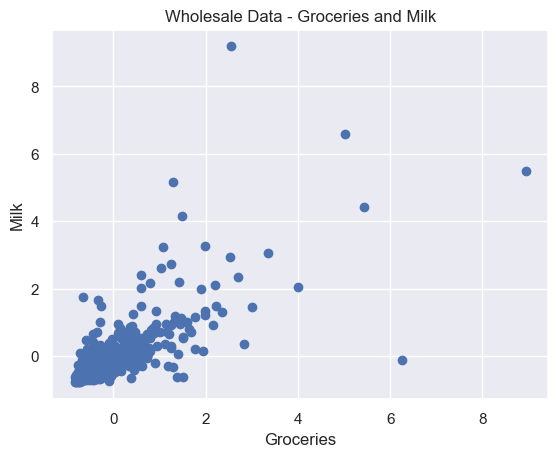

In [17]:
plt.scatter(wholesale_transformed[:, 0], wholesale_transformed[:, 1])
plt.xlabel("Groceries")
plt.ylabel("Milk")
plt.title("Wholesale Data - Groceries and Milk")
#plt.savefig("wholesale.png", format = "PNG")

As you can see, there is positive correlation between grocery purchases and milk product purchases. There is a cluster centered about the mean milk purchase (milk = 0) and the mean groceries purchase (groceries = 0). In addition, there are a handful of outliers pertaining to customers who buy more groceries or milk products compared to other customers.

With DBSCAN, we want to identify this main cluster of customers, but we also want to flag customers with more unusual annual purchasing habits as outliers.

We will construct a DBSCAN object that requires a minimum of 15 data points in a neighborhood of radius 0.5 to be considered a core point.

In [18]:
# Compute clusters from a data or distance matrix and predict labels
dbsc = DBSCAN(eps=0.5, min_samples=15).fit(wholesale_transformed)

Next, we can extract our cluster labels and outliers to plot our results.



In [19]:
# labels_ is the assigned cluster value/id for each of the points provided as input to the algorithm (fit()).  
# Noisy samples are given the label -1.  In the dbsc object, above, two clusters were identified; clusters 0 and -1
labels = dbsc.labels_

# Return an array of zeros with the same shape and type as a given array.
core_samples = np.zeros_like(labels, dtype = bool)

In [20]:
unique_labels = np.unique(labels)
unique_labels

array([-1,  0])

In [21]:
df_wholesale['cluster'] = labels
df_wholesale.sort_values('cluster')

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,cluster
71,18291,1266,21042,5373,4173,14472,-1
251,6134,23133,33586,6746,18594,5121,-1
309,918,20655,13567,1465,6846,806,-1
28,4113,20484,25957,1158,8604,5206,-1
254,10379,17972,4748,4686,1547,3265,-1
...,...,...,...,...,...,...,...
149,31812,1433,1651,800,113,1440,0
148,5924,584,542,4052,283,434,0
147,9203,3373,2707,1286,1082,526,0
118,20049,1891,2362,5343,411,933,0


In [22]:
unique_labels = np.unique(labels)  # identify unique labels in the 'labels' array

# Create a colormap with colors for each unique label.  Spectral is a Matplotlib colormap
# https://matplotlib.org/stable/users/explain/colors/colormaps.html#colormaps
# Generates evenly spaced numbers from 0 to 1, with length equal to the number of unique labels; 
# Creates a color gradient for the colormap
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))

440
440


Text(0, 0.5, 'Milk (scaled)')

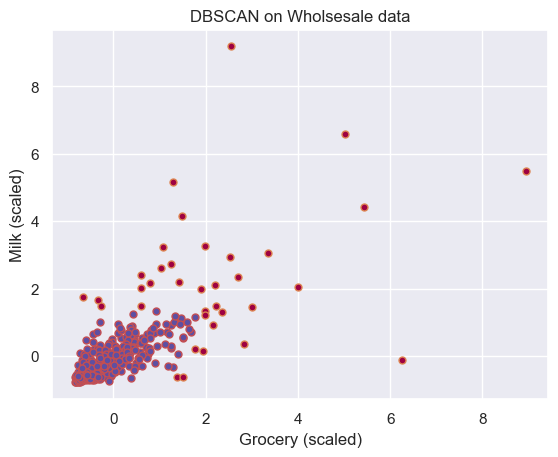

In [23]:
for (label, color) in list(zip(unique_labels, colors)):
    class_member_mask = (labels == label)
    xy = wholesale_transformed[class_member_mask & core_samples]
    print (len(core_samples))
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = wholesale_transformed[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0], xy2[:,1], 'o', markerfacecolor = color, markersize = 5)

plt.title("DBSCAN on Wholsesale data")
plt.xlabel("Grocery (scaled)")
plt.ylabel("Milk (scaled)")
#plt.savefig("dbscan_wholesale.png", format = "PNG")

Lining up with our intuition, the DBSCAN algorithm was able to identify one cluster of customers. In addition, it was able to flag customers whose annual purchasing behavior deviated too heavily from other customers.

Because the outliers corresponded to customers with more extreme purchasing behavior, the wholesale distributor could specifically target these customers with exclusive discounts to encourage larger purchases.

As a baseline, let's run K-Means with two clusters on this dataset. The big blue dot represents the centroid for the black cluster, and the big gold dot represents the centroid for the white cluster.

In [24]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2).fit(wholesale_transformed)  # compute k-means clustering
labels_kmeans = kmeans.labels_
centroids = kmeans.cluster_centers_

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


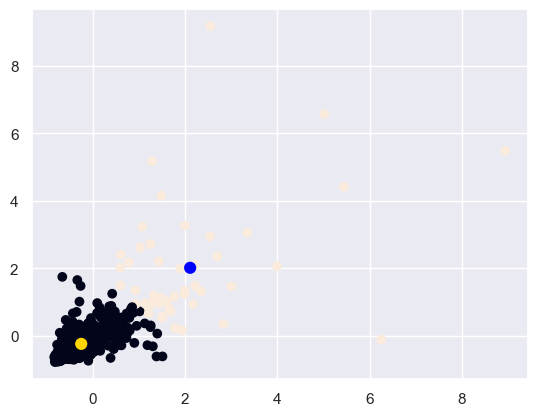

In [25]:
plt.scatter(wholesale_transformed[:,0], wholesale_transformed[:,1], c=labels_kmeans)
plt.scatter(centroids[:,0], centroids[:,1], c=["gold","blue"], s=60)
#plt.savefig("kmeans_wholesale.png", format = "PNG")

While the white clusters appears to capture most of the outliers, the cluster basically captures customers who purchase relatively more goods. If we designate the white cluster as the "anomalous" cluster, then we basically flag any customer who purchases a lot of milk or groceries. If you were the wholesale distributor, then you would be calling your better customers, the ones whom you make more money from, anomalies.

## BEER EXAMPLE CONTINUED

In [26]:
path = 'beer.txt'
beer = pd.read_csv(path, sep=' ')
X = beer.drop('name', axis=1)
print(X.shape)
X.head()

(20, 4)


,calories,sodium,alcohol,cost
0,144,15,4.7,0.43
1,151,19,4.9,0.43
2,157,15,0.9,0.48
3,170,7,5.2,0.73
4,152,11,5.0,0.77


In [27]:
# Center and scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X_scaled.shape)
X_scaled[:5]

(20, 4)


array([[ 0.38791334,  0.00779468,  0.43380786, -0.45682969],
       [ 0.6250656 ,  0.63136906,  0.62241997, -0.45682969],
       [ 0.82833896,  0.00779468, -3.14982226, -0.10269815],
       [ 1.26876459, -1.23935408,  0.90533814,  1.66795955],
       [ 0.65894449, -0.6157797 ,  0.71672602,  1.95126478]])

In [28]:
db = DBSCAN(eps=3, min_samples=3)
db.fit(X_scaled)  # compute clusters from a data or distance matrix and predict labels

DBSCAN(eps=3, min_samples=3)

In [29]:
df_beer_scaled = pd.DataFrame(X_scaled, columns=beer.columns[1:])
display(df_beer_scaled.head())

# review the cluster labels
db.labels_

,calories,sodium,alcohol,cost
0,0.387913,0.007795,0.433808,-0.456830
1,0.625066,0.631369,0.622420,-0.456830
2,0.828339,0.007795,-3.149822,-0.102698
3,1.268765,-1.239354,0.905338,1.667960
4,0.658944,-0.615780,0.716726,1.951265


array([ 0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0])

In [30]:
beer['cluster'] = db.labels_
beer.sort_values('cluster')

df_beer = beer.drop('name', axis=1)
df_beer.groupby('cluster').mean()

,calories,sodium,alcohol,cost
cluster,,,,
-1,157.000000,15.000000,0.900000,0.480000
0,131.263158,14.947368,4.415789,0.495263


In [31]:
beer

,name,calories,sodium,alcohol,cost,cluster
0,Budweiser,144,15,4.7,0.43,0
1,Schlitz,151,19,4.9,0.43,0
2,Lowenbrau,157,15,0.9,0.48,-1
3,Kronenbourg,170,7,5.2,0.73,0
4,Heineken,152,11,5.0,0.77,0
5,Old_Milwaukee,145,23,4.6,0.28,0
6,Augsberger,175,24,5.5,0.40,0
7,Srohs_Bohemian_Style,149,27,4.7,0.42,0
8,Miller_Lite,99,10,4.3,0.43,0
9,Budweiser_Light,113,8,3.7,0.40,0
